<a href="https://colab.research.google.com/github/c-etulle/Vegetation-dynamics-in-the-Subandean-grasslands-of-Chubut/blob/main/3_Import_SPEI_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note CME: Used the new input-SPEI data (based on Penman-Monteith PET equation) ; see mail from CAB 03.09.

# Setup

In [ ]:
!pip install rasterio

import os, sys
import time
import numpy as np
import geopandas as gpd
import pandas as pd
import fnmatch
import matplotlib.pyplot as plt
import ee
import rasterio
import plotly.graph_objs as go
import plotly.express as px
from google.colab import files
from scipy import stats

ee.Authenticate()
ee.Initialize(project='ee-meinzinger-patagonia')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # dt. einbinden
#change working directory:
%cd /content/drive/My\ Drive/ee-meinzinger-patagonia

Mounted at /content/drive
/content/drive/My Drive/ee-meinzinger-patagonia


In [ ]:
import rasterio
print(rasterio.__version__)

1.4.3


# 1) Import SPEI data

## a) Define functions for importing

In [ ]:
def get_point_data(inPath, field_name, pts, coords):
    src = rasterio.open(inPath)
    pts[field_name] = [x[0] for x in src.sample(coords)]
    return pts

def findRasters(path, filter):
    for root, dirs, files in os.walk(path):
        for file in fnmatch.filter(files, filter):
            file = path + "/" + file
            yield file
        break

## b) Data paths

In [ ]:
path_points = r"Data/Chubut_samples.shp"
path_data   = r"Data_SPEI"

year_range = range(2000, 2023)
months = ["01", "02", "03",  "04", "05", "06", "07", "08", "09", "10", "11", "12"]

## c) Get lat long coordinates for all field sites and remove duplicates

In [ ]:
# read file as geoPandas dataframe
pts = gpd.read_file(path_points)

# Select only latitude, longitude and site name
pts = pts[['Latitude', 'Longitude', 'Site_Name']]

# Remove duplicates
pts = pts.drop_duplicates(keep='first')

# Make a list with all coordinates
coords = [(x,y) for x, y in zip(pts['Longitude'], pts['Latitude'])]

pts

,Latitude,Longitude,Site_Name
0,-45.440611,-70.300306,CERM
3,-45.426750,-70.267778,La Ana
6,-45.585306,-71.390694,Media Luna
9,-45.567278,-71.313250,Alto Río Mayo
12,-44.204611,-66.015111,1 San Felipe
...,...,...,...
249,-44.698583,-70.925722,LAS MERCEDES
251,-44.537889,-70.344000,Nueva Lubecka
254,-43.391583,-70.743722,El Poyo
256,-42.802639,-70.324833,El Saucal


## d) Make a copy of data frame called pts_drought_read

This is for reading the SPEI values from the TIF files. Later I will remove lattitude and longitue columns and call it "pts_drought".

In [ ]:
pts_drought_read = pts.copy()

## e) Get SPEI data at the plot locations (coordinates)

Example: for year 2022, month 12, one of the raster files is called "spei06_5km_2022_12_Chubut.tif". This file will then be detected and the "get_point_data" function will extract the SPEI values of all the coordinates for this tif file, and then store these values in the pts_drought data frame under their corresponding year and month.

Note: no need for a loop over the rasters, since there is only one file per year and month, but maybe it just works better like this.

The warning messages appear randomly, they should not be a problem.

In [ ]:
for year in year_range: # for each year
    for m in months: # for each month
        for raster in findRasters(path_data, "spei*" + str(year) + "_" + str(m) + "*.tif"): # loop over all raster (tif) files (no loop necessary really)
            #print(raster)
            get_point_data(raster, str(year) + str(m) , pts_drought_read, coords) # Get the SPEI data

<ipython-input-3-71bc0ab89f73>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pts[field_name] = [x[0] for x in src.sample(coords)]
<ipython-input-3-71bc0ab89f73>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pts[field_name] = [x[0] for x in src.sample(coords)]
<ipython-input-3-71bc0ab89f73>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

##f) Remove the lattidue and longitude columns

In [ ]:
pts_drought = pts_drought_read.iloc[:,2:]

In [ ]:
pts_drought

,Site_Name,200001,200002,200003,200004,200005,200006,200007,200008,200009,...,202203,202204,202205,202206,202207,202208,202209,202210,202211,202212
0,CERM,-0.813071,-0.531295,-0.411697,0.126315,0.385927,0.271689,0.160641,-0.461901,0.387128,...,-0.688510,-0.074080,-0.142551,-0.032422,-0.190797,-0.684662,-0.405283,-0.932429,-0.975499,-0.391333
3,La Ana,-0.783111,-0.504406,-0.385948,0.160207,0.428115,0.331129,0.237738,-0.381703,0.507103,...,-0.637496,0.012185,-0.011638,0.096884,-0.080303,-0.581716,-0.294664,-0.866399,-0.933547,-0.367457
6,Media Luna,-1.649658,-1.542279,-1.221749,-0.686897,-0.908912,-1.164397,-1.288085,-1.529917,-1.457009,...,-0.090564,-0.031873,-0.149154,-0.109004,-0.169331,-0.461367,-0.330441,-0.650096,-0.856629,-0.055589
9,Alto Río Mayo,-1.531504,-1.394958,-1.075082,-0.491075,-0.694021,-0.984798,-1.168768,-1.467488,-1.346866,...,-0.227511,-0.127341,-0.208958,-0.167885,-0.114212,-0.459518,-0.336057,-0.659154,-0.881930,-0.111790
12,1 San Felipe,0.855075,1.536438,1.433884,1.094649,0.759859,1.166212,1.395803,0.806849,1.552023,...,0.342742,0.801215,0.216013,-0.086819,-0.187533,-0.508537,0.479347,0.294409,0.780236,0.815614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,LAS MERCEDES,-1.793581,-1.294554,-0.914356,-0.422300,-0.361510,-0.406663,-0.571249,-0.785246,-0.680681,...,-0.271087,0.186832,0.149851,0.114713,0.339374,0.026502,0.322859,-0.139787,-0.307518,0.168421
251,Nueva Lubecka,-0.955758,-0.708613,-0.629381,-0.345823,-0.125787,-0.039212,-0.198000,-0.441106,0.149731,...,-0.775765,0.196906,0.256400,0.394478,0.963317,0.685902,1.152333,0.462181,0.251687,0.409156
254,El Poyo,-0.054394,0.199040,-0.220528,0.028710,-0.134944,0.278674,0.003481,-0.498608,-0.085466,...,0.631636,1.199767,0.930407,1.143589,1.446969,0.955994,1.372802,0.705379,0.747518,0.600688
256,El Saucal,0.461740,0.509877,0.011568,0.144197,-0.021402,0.721525,0.588717,0.400964,1.073138,...,0.432646,0.881466,0.735258,0.491094,0.514745,-0.036807,0.432191,0.122619,0.251893,0.442854


## g) Save the results as csv

In [ ]:
# Save the DataFrame as a CSV file
pts_drought.to_csv('pts_drought.csv', index=False)

# Download the file
#files.download('pts_drought.csv')

# 2) Example plotting of SPEI data

## a) Plot SPEI for 1 sample location

**Note:** I choose Yague.

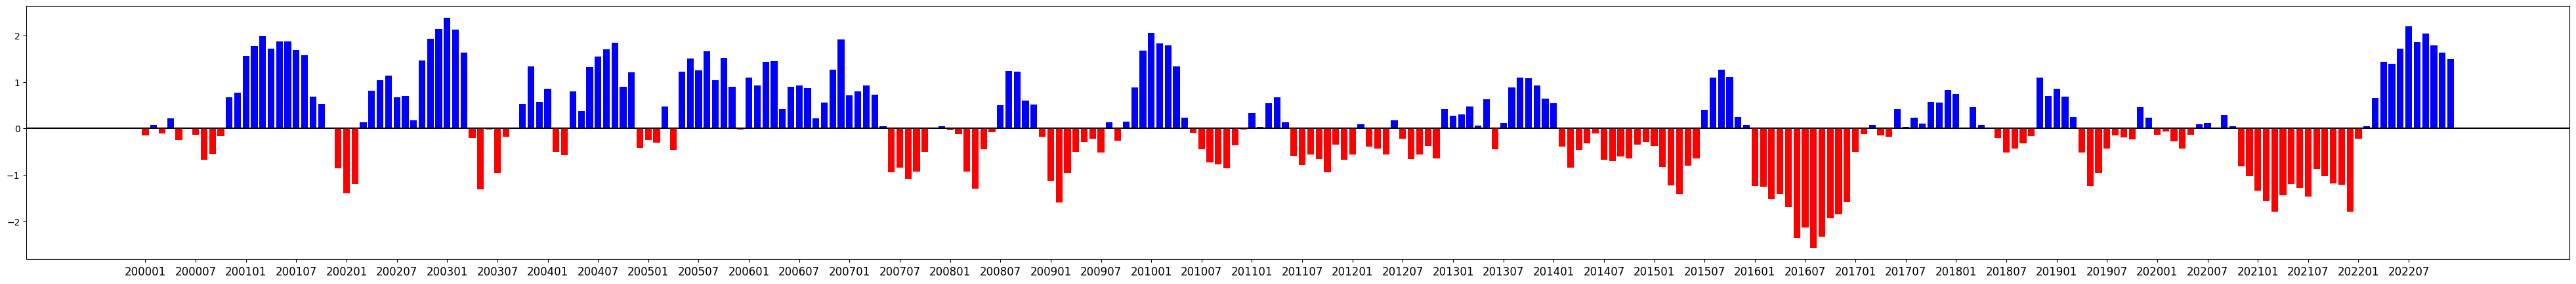

In [ ]:
# select field site by Name
pts_plot = pts_drought[pts_drought['Site_Name']== "Yague"].values[0][1:]

# define x-axis values
pts_plot_range = pts_drought.columns[1:].values

# define color of the bars positive values /wet years in blue and negative values/dry years in red
spei_color = []
for p in pts_plot:
    if p < 0:
        spei_color.append('red')
    elif p > 0:
        spei_color.append('blue')
    else:
        spei_color.append('lightgray')

# plot time series
fig, ax = plt.subplots(figsize=(50, 5))
plt.bar(pts_plot_range, pts_plot, color=spei_color)

plt.axhline(y=0, c='black', ls="-")
#plt.axhline(y=-1, c='red', ls="--")

plt.xticks(range(0, len(pts_plot_range), 6), fontsize=12)

plt.show()

## b) Plot SPEI across all sample locations

### Get the monthly mean, median and max. SPEI across sample locations

Mean and max values do not make sense here, since there are coordinates that have extremely high values. These sites are removed in the other scripts.

In [ ]:
# 1. Extract the year-month columns (excluding 'Site_Name')
year_month_columns = pts_drought.columns[1:]

# 2. Compute summary statistics
mean_values = pts_drought[year_month_columns].mean()
median_values = pts_drought[year_month_columns].median()
max_values = pts_drought[year_month_columns].max()

# 3. Combine the results into a single DataFrame
summary_df = pd.DataFrame({
    'Year_Month': year_month_columns,
    'Mean_Value': mean_values,
    'Median_Value': median_values,
    'Max_Value': max_values
})

# Sort the summary DataFrame by 'Year_Month'
summary_df = summary_df.sort_values(by='Year_Month').reset_index(drop=True)

summary_df

,Year_Month,Mean_Value,Median_Value,Max_Value
0,200001,5.825243e+28,0.057989,1.000000e+30
1,200002,3.883495e+28,0.199040,1.000000e+30
2,200003,3.883495e+28,-0.195989,1.000000e+30
3,200004,3.883495e+28,-0.108531,1.000000e+30
4,200005,3.883495e+28,-0.125787,1.000000e+30
...,...,...,...,...
271,202208,5.825243e+28,0.026502,1.000000e+30
272,202209,5.825243e+28,0.578239,1.000000e+30
273,202210,5.825243e+28,0.260649,1.000000e+30
274,202211,5.825243e+28,0.451109,1.000000e+30


### Plot median values

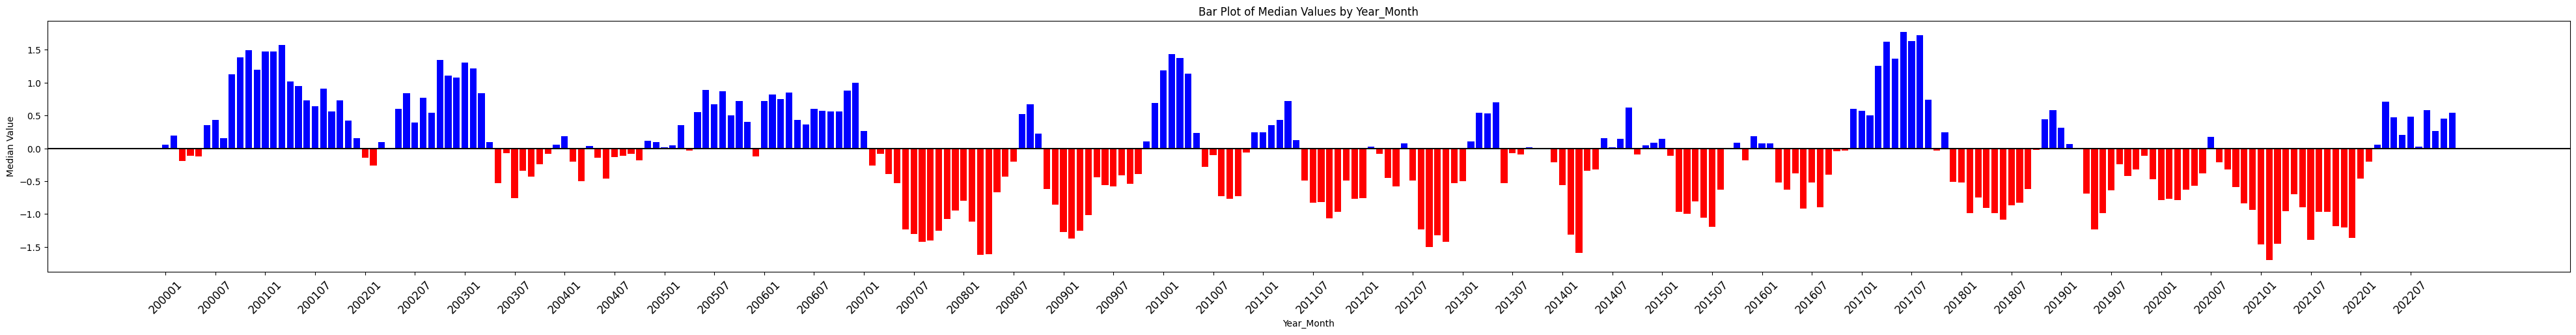

In [ ]:
# 1. Create a color list: red for positive values, blue for negative values
colors = ['blue' if value > 0 else 'red' for value in summary_df['Median_Value']]

# 2. Create the bar plot
plt.figure(figsize=(50, 5))  # Optional: Set the figure size
plt.bar(summary_df['Year_Month'], summary_df['Median_Value'], color=colors)

# 3. Add labels and title
plt.xlabel('Year_Month')
plt.ylabel('Median Value')
plt.title('Bar Plot of Median Values by Year_Month')

# 4. Rotate x-axis labels if needed (optional)
plt.xticks(rotation=45)

# What is this?
plt.axhline(y=0, c='black', ls="-")

# 5. Show the plot
plt.xticks(range(0, len(pts_plot_range), 6), fontsize=12)
plt.show()

## c.) Plot SPEI trend line for all sample locations (median)

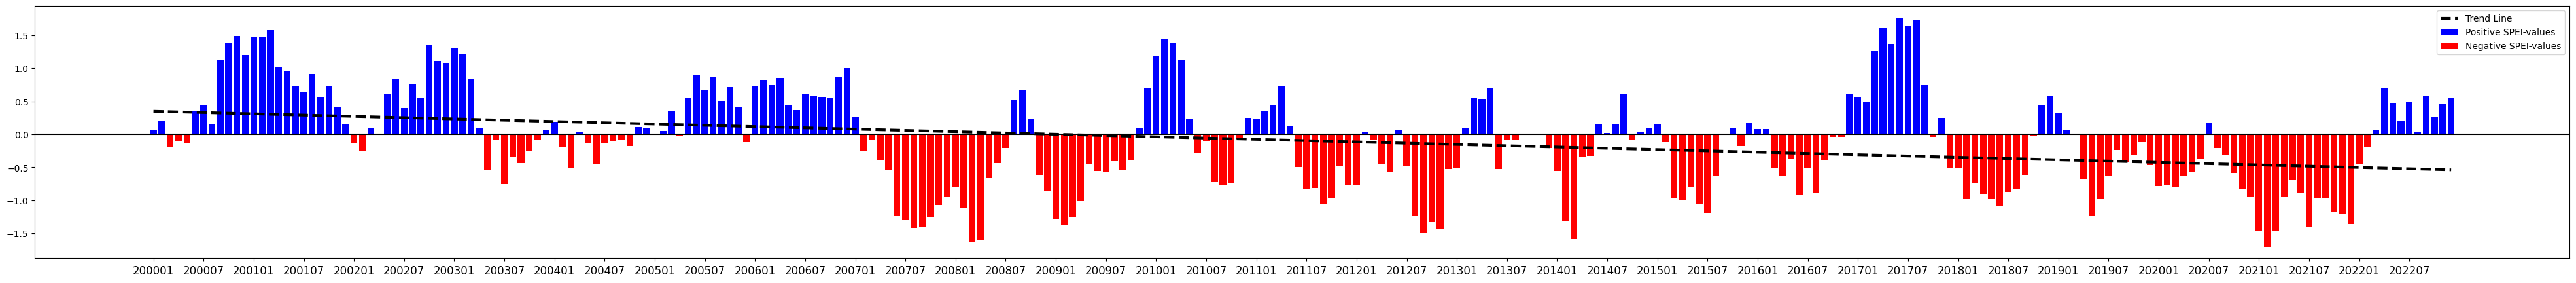

In [ ]:
# data input
pts_plot = summary_df['Median_Value']

# define x-axis values
pts_plot_range = pts_drought.columns[1:].values

# Fit a linear trend line
coefficients = np.polyfit(range(len(pts_plot_range)), pts_plot, 1)
trend_line = np.poly1d(coefficients)
trend_values = trend_line(range(len(pts_plot_range)))

# Create two separate arrays: one for positive values (for blue bars) and one for negative values (for red bars)
positive_values = [val if val > 0 else 0 for val in pts_plot]  # Replace negative values with 0 for blue bars
negative_values = [val if val < 0 else 0 for val in pts_plot]  # Replace positive values with 0 for red bars

# plot time series
fig, ax = plt.subplots(figsize=(50, 5))

# Plot positive values as blue bars
plt.bar(pts_plot_range, positive_values, color='blue', label='Positive SPEI-values')

# Plot negative values as red bars
plt.bar(pts_plot_range, negative_values, color='red', label='Negative SPEI-values')

# Plot the trend line
plt.plot(pts_plot_range, trend_values, color='black', linestyle='--', linewidth=3, label='Trend Line')

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-')

# Customize x-axis ticks
plt.xticks(range(0, len(pts_plot_range), 6), fontsize=12)

# Show the plot
plt.legend()
plt.show()